# Theorie

## Der Bingham-Hooke-Körper

Als rheologisches Modell für <b>Viskoplastizität</b> betrachten wir den <b>Bingham-Hooke-Körper</b>:
<p><img src="bingham-hooke.png" width="400"/></p>

Wie bei der Viskoelastizität wird wiederum entweder die Spannung $\sigma$ oder die Dehnung $\varepsilon$ vorgeschrieben und die jeweils andere Größe berechnet. Im Folgenden werden, wo nicht explizit andere Werte genannt werden, die folgenden <b>Materialparameter</b> verwendet:

| Element               | Parameter  | Wert | Einheit |
|:---------------------:|:----------:|:----:|:-------:|
| Hooke-Element         | $E$        | 200  | MPa     |
| Newton-Element        | $\eta$     |  50  | MPa s   |
| St.-Venant-Element    | $\sigma_y$ |  10  | MPa     |

Die Spannungen und Dehnungen an den <b>einzelnen Elementen</b> bezeichnen wir wie folgt:

| Element                         | Dehnung               | Spannung            |
|:-------------------------------:|:---------------------:|:-------------------:|
| Hooke-Element ($E$)             | $\varepsilon_\mathrm{e}$       | $\sigma_\mathrm{e}$          |
| Newton-Element ($\eta$)         | $\varepsilon_\mathrm{v}$       | $\sigma_\mathrm{v}$          |
| St.-Venant-Element ($\sigma_y$) | $\varepsilon_\mathrm{p}$       | $\sigma_\mathrm{p}$          |

Aus den Beziehungen für die <b>Parallelschaltung</b> ergeben sich folgende Gleichungen:

$$\begin{aligned}
\varepsilon_\mathrm{vp} & = \varepsilon_\mathrm{v} = \varepsilon_\mathrm{p} \\
\sigma_\mathrm{vp} & = \sigma_\mathrm{v} + \sigma_\mathrm{p} \\
\end{aligned}$$

Aus den Beziehungen für die <b>Reihenschaltung</b> ergeben sich folgende Gleichungen:

$$\begin{aligned}
\varepsilon & = \varepsilon_\mathrm{e} + \varepsilon_\mathrm{vp} \\
\sigma & = \sigma_\mathrm{e} = \sigma_\mathrm{vp}
\end{aligned}$$

mit $\varepsilon_\mathrm{vp}$ die im Folgenden zu lösende interne Variable.

Für die <b>Spannungs-Dehnungs-Beziehung</b> gelten an den drei Elementen die folgenden Gleichungen:

$$\begin{aligned}
\sigma_\mathrm{e} & = E \, \varepsilon_\mathrm{e} \\
\sigma_\mathrm{v} & = \eta \, \dot \varepsilon_\mathrm{vp} \\
\sigma_\mathrm{p} & \left\{ \begin{matrix}
    = +\sigma_y               & \text{für } \dot \varepsilon_\mathrm{vp} > 0 \\
    \in \left[-\sigma_y, \sigma_y\right] & \text{für } \dot \varepsilon_\mathrm{vp} = 0 \\
    =-\sigma_y                & \text{für } \dot \varepsilon_\mathrm{vp} < 0
    \end{matrix} \right.
\end{aligned}$$
### Bestimmung der Spannung
Anhand der obigen Gleichungen lässt sich die <b>Spannung</b> über eine Fallunterscheidung lösen:

$$\begin{aligned}
\sigma & = \sigma_\mathrm{e} = E \, \varepsilon_\mathrm{e} = E \left[\varepsilon - \varepsilon_\mathrm{vp}\right] \\
\dot{\varepsilon}_\mathrm{vp} & = \frac{\sigma_\mathrm{v}}{\eta} = \frac{\sigma_\mathrm{vp} - \sigma_\mathrm{p}}{\eta} = \frac{\sigma - \sigma_\mathrm{p}}{\eta} \\
& = \left\{ \begin{matrix}
    \dfrac{\sigma - \sigma_y}{\eta} & \hspace{-1.2cm} \text{für } \sigma_\mathrm{vp} = \sigma \geq + \sigma_y  \\
    0                               &                 \text{für } \sigma_\mathrm{vp} = \sigma \in [-\sigma_y + \sigma_y] \\
    \dfrac{\sigma + \sigma_y}{\eta} & \hspace{-1.2cm} \text{für } \sigma_\mathrm{vp} = \sigma \leq - \sigma_y
    \end{matrix} \right.
\end{aligned}$$

Die <b>Evolutionsleichung</b> $\dot{\varepsilon}_\mathrm{vp}$ kann durch drei Gleichungen vereinfacht ausgedrückt werden:

$$\begin{aligned}
\dot \varepsilon_\mathrm{vp} & = \lambda \frac{\sigma}{\left\vert\sigma\right\vert} \ ,\\
\lambda & = \frac{\max\left\{0,\Phi\right\}}{\eta} \geq 0 \\
\Phi & = \left\vert\sigma \right\vert - \sigma_y
\end{aligned}$$
### Numerische Integration

Die Spannung ergibt sich in der Zeit diskretisierten Form zu:
$$\sigma_{n+1} = E \left[\varepsilon_{n+1} - \varepsilon_{\mathrm{vp},n+1}\right]$$

Die viskoplastische Dehnung erhält man über die <b>implizite Euler Zeitintegration</b> angewandt auf die Evolutionsgleichung $\dot{\varepsilon}_\mathrm{vp}$:

$$\begin{aligned}
\frac{\varepsilon_{\mathrm{vp},n+1} - \varepsilon_{\mathrm{vp},n}}{\Delta t} = \dot \varepsilon_{\mathrm{vp},n+1} = \lambda \frac{\sigma_{n+1}}{\left\vert\sigma_{n+1}\right\vert} = \lambda \, \frac{\sigma^\mathrm{tr}}{\left\vert\sigma^\mathrm{tr}\right\vert} \\
\varepsilon_{\mathrm{vp},n+1} = \varepsilon_{\mathrm{vp},n} + \Delta\lambda  \, \frac{\sigma^\mathrm{tr}}{\left\vert\sigma^\mathrm{tr}\right\vert} \\
\Delta\lambda = \Delta t \, \frac{\mathrm{max}\{0, \varPhi_{n+1}\}}{\eta} = \frac{\Delta t}{\eta + E \, \Delta t} \, \mathrm{max}\{0, \varPhi^\mathrm{tr}\}
\end{aligned}$$

### Predictor-Corrector-Methode
Um zwischen *elastischen* und *viskoplastischen* Zuständen zu unterscheiden, wird eine so genannten <b>Predictor-Corrector-Methode</b> verwendet. Zunächst werden, unter der Annahme dass der Zeitschritt <b>rein elastisch</b> ist, d.h. $\Delta \lambda = 0$, <b>Trial-Werte</b> für den neuen Zeitschritt bestimmt:

$$\begin{aligned}
\Phi^\mathrm{tr} & = \left\vert\sigma^\mathrm{tr} \right\vert - \sigma_y \\
\sigma^\mathrm{tr} & = E \left[ \varepsilon - \varepsilon_\mathrm{vp}^\mathrm{tr} \right] \\
\varepsilon_\mathrm{vp}^\mathrm{tr} & = \varepsilon_{\mathrm{vp},n}
\end{aligned}$$

Anschließend wird anhand der <b>Fließfunktion</b> ebendiese Annahme überprüft. Wenn die Bedingung $\Phi^\mathrm{tr} \leq 0$ erfüllt ist, dann ist mit $\Delta \lambda = 0$ der Zeitschritt tatsächlich <b>rein elastisch</b>, und die Trial-Werte werden als Lösung übernommen:
$$\begin{aligned}
\sigma & = \sigma^\mathrm{tr} \\
\varepsilon_\mathrm{vp} & = \varepsilon_\mathrm{vp}^\mathrm{tr}
\end{aligned}$$

Andernfalls gilt $\Phi^\mathrm{tr} > 0$ mit $\Delta \lambda > 0$ und ein <b>viskoplastischer Zeitschritt</b> findet statt. Die folgende <b>Korrektur</b> wird umgesetzt:

$$\begin{aligned}
\sigma & = E \left[ \varepsilon - \varepsilon_\mathrm{vp} \right] \\
\varepsilon_\mathrm{vp} & = \varepsilon_{\mathrm{vp},n} +\Delta \lambda \frac {\sigma^\mathrm{tr}}{\left\vert\sigma^\mathrm{tr}\right\vert}\\
\Delta \lambda & = \frac{\Delta t}{\eta + E \Delta t} \Phi^\mathrm{tr}
\end{aligned}$$


# Umsetzung in Python

Um das Verhalten des Modells zu untersuchen, werden wir die oben hergeleiteten Gleichungen in Python implementieren.
## Python-Umgebung

In diesem Abschnitt wird die Umgebung für das Arbeiten im Notebook vorbereitet. 

## Import aller verwendeten Bibliotheken

Zunächst werden alle relevanten Pakete für Python importiert:

In [1]:
import numpy as np
from scipy.optimize import fsolve, root
from scipy import signal
import matplotlib.pyplot as plt

## Standard-Look für Plots

Dann werden einige Standard-Einstellungen für das Paket *matplotlib* gesetzt. Diese beeinflussen alle Plots die wir erstellen - so können später mit kleinen Änderungen in diesem Bereich alle Plots gleichzeitig angepasst werden. Typische Beispiele sind Schriftgrößen, Linienstärken etc. Eine Übersicht über die Einstellungsmöglichkeiten findet man z.B. [hier](https://matplotlib.org/stable/tutorials/introductory/customizing.html).

In [2]:
# Dieser Befehl öffnet ein neues Fenster für Plots anstatt sie im Notebook anzuzeigen:
#%matplotlib qt

# Optische Einstellungen
plt.rcParams['figure.figsize'] = [15,6]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14



## Bestimmung der Spannungen für gegebene Dehnungen

Es soll zunächst eine Funktion erstellt werden, welche die Spannung $\sigma$ und die interne Variable $\varepsilon_\mathrm{vp}$ zu einer <b>vorgegebenen Dehnung</b> $\varepsilon$ bestimmt. Dazu werden der Funktion die Materialparameter $E$, $\eta$ und $\sigma_y$ sowie die interne Variable aus dem vorherigen Zeitschritt $\varepsilon_{\mathrm{vp},n}$ und die Zeitschrittweite $\Delta t$ übergeben.

---
**Aufgabe**

Vervollständige die Funktion `stress` in der nächsten Zelle.

---

### Zusammenfassung

$$\begin{align*}
&\text{Trial step}: \quad \quad \quad \quad \quad
&&\text{Falls } \Phi^\mathrm{tr} \leq 0: \quad \quad \quad \quad \quad 
&&\text{Falls } \Phi^\mathrm{tr} > 0:
\end{align*}$$

$$\begin{align*}
&\begin{aligned}
\varepsilon_\mathrm{vp}^\mathrm{tr} & = \varepsilon_{\mathrm{vp},n} \\
\sigma^\mathrm{tr} & = E \left[ \varepsilon - \varepsilon_\mathrm{vp}^\mathrm{tr} \right] \\
\Phi^\mathrm{tr} & = \left\vert\sigma^\mathrm{tr} \right\vert - \sigma_y
\end{aligned}
&& \quad \quad \quad \quad 
\begin{aligned}
\sigma & = \sigma^\mathrm{tr} \\
\varepsilon_\mathrm{vp} & = \varepsilon_\mathrm{vp}^\mathrm{tr}
\end{aligned}
&& \quad \quad \quad \quad
\begin{aligned}
\Delta \lambda & = \frac{\Delta t}{\eta + E \Delta t} \Phi^\mathrm{tr} \\
\varepsilon_\mathrm{vp} & = \varepsilon_{\mathrm{vp},n} +\Delta \lambda \frac {\sigma^\mathrm{tr}}{\left\vert\sigma^\mathrm{tr}\right\vert} \\
\sigma & = E \left[ \varepsilon - \varepsilon_\mathrm{vp} \right] 
\end{aligned}
\end{align*}$$

In [3]:
def stress(eps, epsvp_n, dt, E, sigy, eta):
       
    # viskoplastische trial Dehnungen
    epsvp_tr = epsvp_n
    
    # trial Spannung
    sig_tr = E*(eps - epsvp_tr)
    
    # trial Fließfunktion
    phi_tr = np.abs(sig_tr) - sigy
    
    # ueberpruefe ob Zustand viskoplastisch ist
    if phi_tr <= 0:
        # ist elastisch
        
        # update der Spannung
        sig = sig_tr
        
        # update der viskoplastischen Dehnungen
        epsvp = epsvp_tr
        
    else:
        # ist viskoplastisch
        
        # viskoplastischer Multiplikator
        dlambda = dt/(eta + E*dt)*phi_tr
        
        # update der viskoplastischen Dehungen
        epsvp = epsvp_n + dlambda*np.sign(sig_tr) #*sig_tr/np.abs(sig_tr)
        
        # update der Spannung
        sig = E*(eps - epsvp)
    
    return sig, epsvp

In [4]:
from musterloesungen import test_stress
test_stress(stress)

Die Funktion ist korrekt.


## Beispiel: Zyklische Last, dehnungsgesteuert

Die neue Funktion soll nun verwendet werden, um die Spannungen und internen Variablen während zyklischer Dehnung zu bestimmen. Dabei soll die Dehnung zunächst $2\,\mathrm{s}$ konstant auf Null gehalten und dann mit einer Dehnrate von $0.1\, \mathrm{s}^{-1}$ auf einen Maximalwert von $0.2$ gesteigert werden. Anschließend soll die Dehnung für $2\,\mathrm{s}$ konstant gehalten werden, bevor die Lastumkehr erfolgt und die Dehnung mit der gleichen Dehnrate wie zuvor bis auf den Wert $-0.2$ gesenkt wird. Nach weiteren $2\,\mathrm{s}$ Haltezeit wird die Dehnung schließlich wieder auf den Wert $0$ gebracht. Siehe:

<p><img src="prescribed_strains.png" width="800"/></p>

---
**Aufgabe**

Vervollständige den Programmcode in der folgenden Zelle, um die gewünschte Dehnung vorzuschreiben.

---

**Hinweis**:
Für diese Aufgabe könnten die numpy-Funktionen [`np.arange`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) und [`np.heaviside`](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html) und/oder die Funktion [`scipy.signal.sawtooth`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html) aus der Bibliothek scipy hilfreich sein...

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


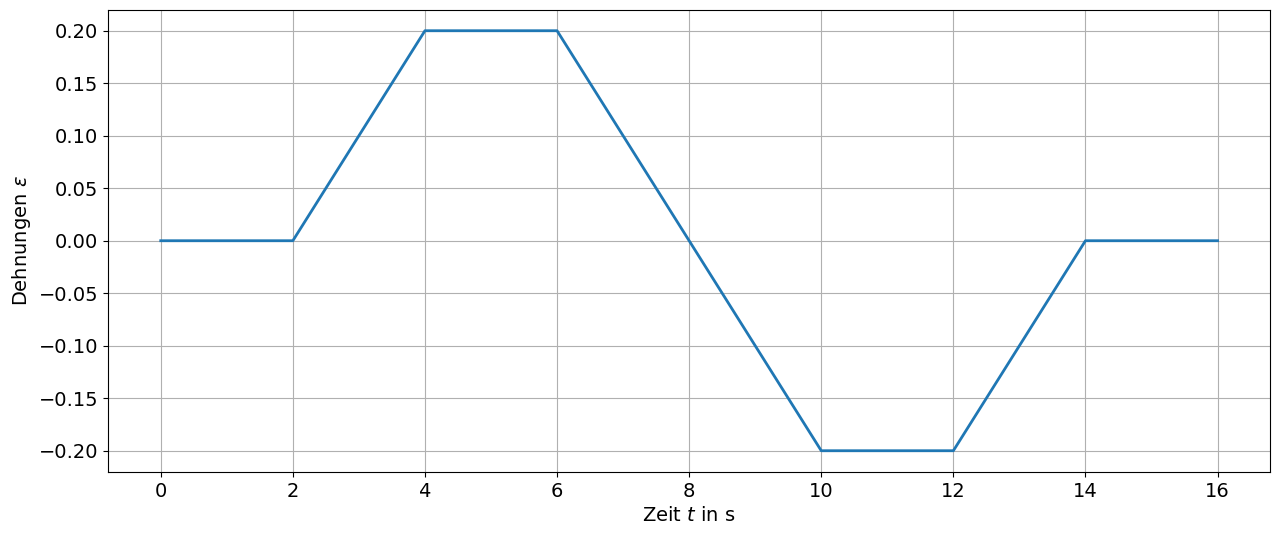

In [5]:
# Materialparameter
E = 200.
eta = 50.
sigy = 10.

# Diskrete Zeiten und Dehnungen
tmin = 0.
dt = 0.1

epsmax = 0.2
deps = 0.1 # Rate pro s
Ts = epsmax/deps # Zeit für Rampe
Th = 2. # Haltezeit

T1 = Th
T2 = Th+Ts
T3 = 2*Th+Ts
T4 = 2*Th+3*Ts
T5 = 3*Th+3*Ts
T6 = 3*Th+4*Ts

tmax = 4*Th+4*Ts

t = np.arange(0, 1+dt, dt)
print(t)

eps = np.heaviside(t-0.5,1)
print(eps)

t = np.arange(tmin, tmax+dt, dt)

eps = (np.heaviside(t-T1,0)*(t-T1)*deps
      -np.heaviside(t-T2,0)*(t-T2)*deps
      -np.heaviside(t-T3,0)*(t-T3)*deps
      +np.heaviside(t-T4,0)*(t-T4)*deps
      +np.heaviside(t-T5,0)*(t-T5)*deps
      -np.heaviside(t-T6,0)*(t-T6)*deps)

plt.plot(t, eps)
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$');

---
**Aufgabe**

Vervollständige den Programmcode in der folgenden Zelle, um zu jeder der vorgeschriebenen Dehnungen die zugehörige Spannung $\sigma$ und interne Variable $\varepsilon_{vp}$ zu bestimmen.

---

**Hinweise**:
- Du solltest die folgende Zelle erst dann bearbeiten, wenn die Dehnungen in der vorherigen Zelle korrekt sind.
- Für den ersten Zeitpunkt $t=0$ gehen wir davon aus, dass die interne Variable den Wert 0 hat.

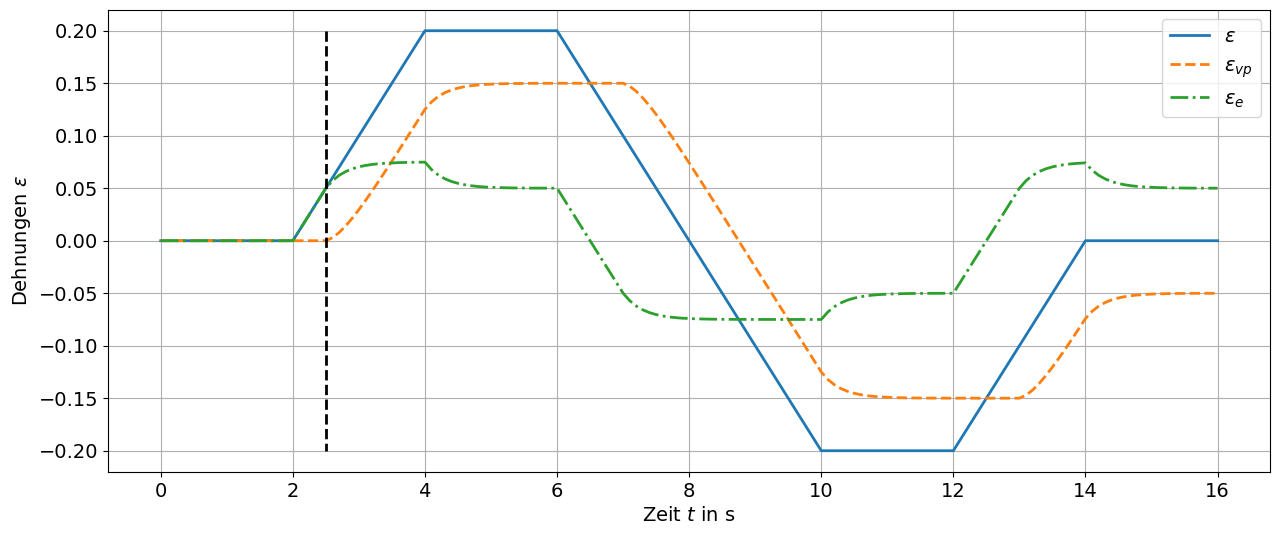

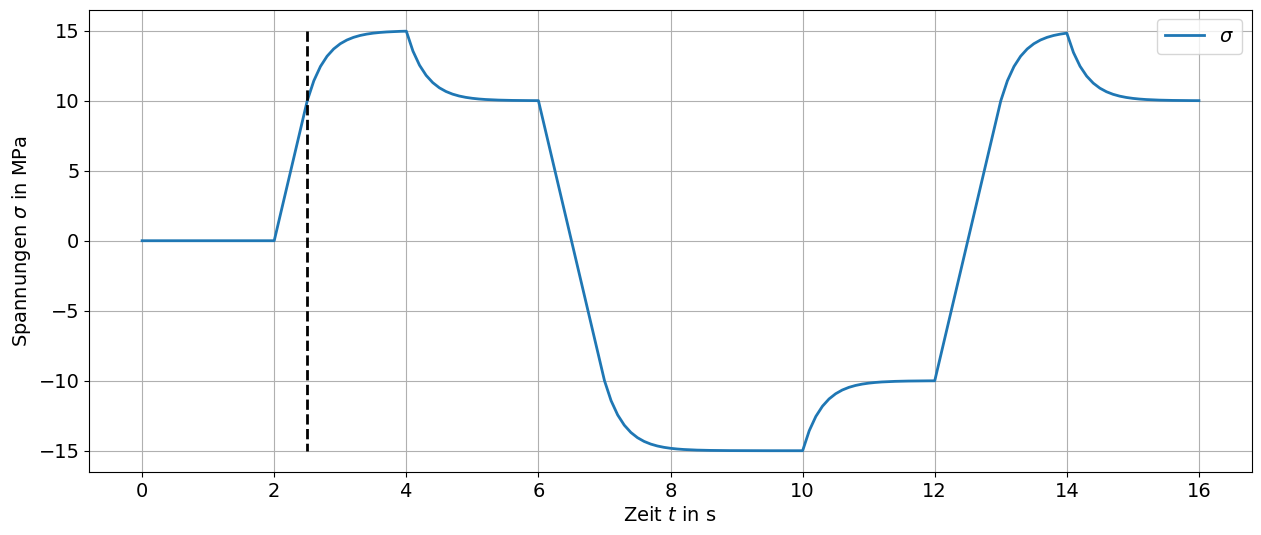

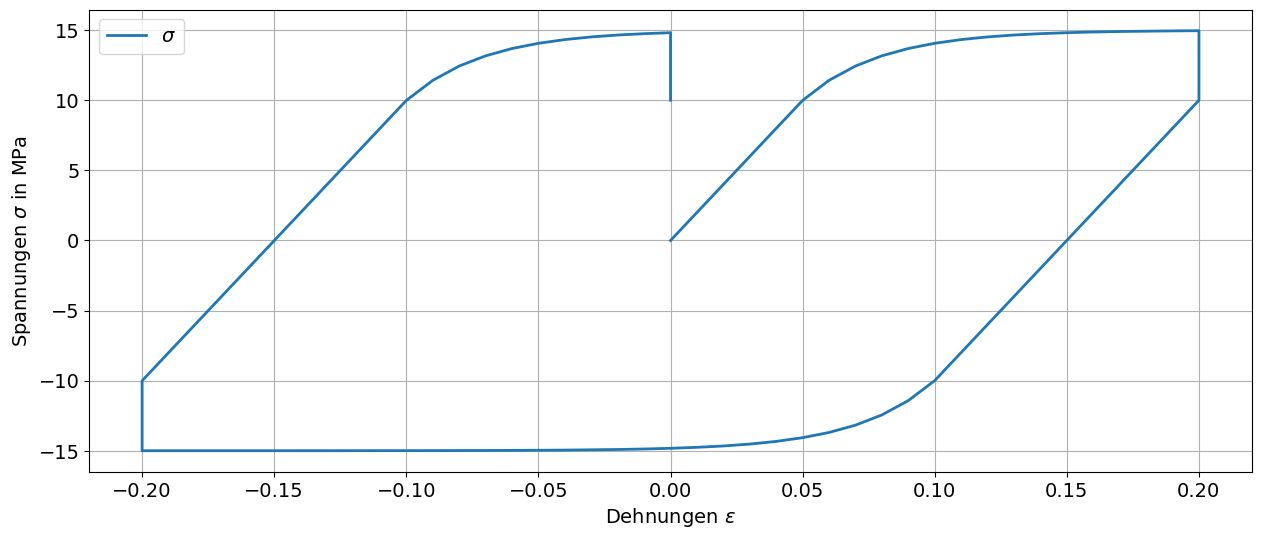

In [6]:
# Leere Arrays für Spannung und interne Variable
sig = np.zeros_like(eps)
epsvp = np.zeros_like(eps) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

# Schleife über Zeitschritte
for i in range(1,len(eps)):
    sig[i], epsvp[i] = stress(eps[i], epsvp[i-1], dt, E, sigy, eta)

plt.plot(t, eps, label=r'$\varepsilon$')
plt.plot(t, epsvp, '--', label=r'$\varepsilon_{vp}$')
plt.plot(t, eps - epsvp, '-.', label=r'$\varepsilon_{e}$')
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$')

epsx = sigy/E; tx = epsx/deps + Th
plt.plot([tx, tx],[epsmax,-epsmax], 'k--')

plt.figure()
plt.plot(t, sig, label=r'$\sigma$')
plt.legend()
plt.xlabel('t');
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$');
plt.plot([tx, tx],[sigy+eta*deps,-sigy-eta*deps], 'k--')

plt.figure()
plt.plot(eps, sig, label=r'$\sigma$')
plt.legend()
plt.xlabel(r'Dehnungen $\varepsilon$')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$');

# Numerische Lösung des Gleichungssystems

Analog zur Viskoelatizität formulieren wir die Evolutionsgleichung und die Spannungs-Dehnungs-Beziehung im residualen Format.

$$
\mathbf{r} = \begin{bmatrix}
\sigma - E \left[\varepsilon - \varepsilon_{vp}\right] \\
\varepsilon_{vp} - \varepsilon_{vp,n} - \Delta \lambda \dfrac{\sigma}{\left| \sigma \right|}\\
\Delta \lambda \eta - \Delta t \max \left\{0, \Phi\right\} \\
\Phi - \left| \sigma \right| + \sigma_y
\end{bmatrix} = \mathbf 0
\ .$$

Das resultierende Gleichungssystem soll wieder mit der scipy-Funktion `fsolve` gelöst werden.

---
**Aufgabe**

Vervollständige die Funktion `res` zur Bestimmung des Residuums.

---


In [7]:
# Residuum für gegebene Dehnungen, Spannungen und viskose Verzerrungen
def res(eps, sig, epsvp, dlambda, phi, epsvp_n, dt, E, sigy, eta):
    
    r1 = sig - E*(eps - epsvp)
    r2 = epsvp - epsvp_n - dlambda*np.sign(sig) #*sig/np.abs(sig)
    r3 = dlambda*eta - dt*max(0,phi)
    r4 = phi - np.abs(sig) + sigy
    
    return np.array([r1, r2, r3, r4])

Wie du deine Antwort überprüfst erkläre ich jetzt nicht schon wieder...

In [8]:
from musterloesungen import test_residuum
test_residuum(res)

Die Funktion ist korrekt.


## Gleichungslöser

Es gilt nun, die Gleichung $\boldsymbol r = \boldsymbol 0$ nach den Variablen $\sigma$ und $\varepsilon_{vp}$ zu lösen. Wir verwenden wieder die Funktion [`fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) aus dem Paket `scipy`.

---
**Aufgabe**

Vervollständige die Funktion `stress_res` zur Bestimmung der Spannungen und internen Variablen basierend auf der Residuumsfunktion über eine Python-Lambda funktion.

---


In [9]:
# Lösung der Residuumsgleichung nach den Spannungen und viskosen Verzerrungen
def stress_res(eps, epsvp_n, dt, E, sigy, eta, x0 = np.zeros(4)):
    
    #             res(eps, sig,  epsvp, dlambda, phi,  epsvp_n, dt, E, sigy, eta)
    f = lambda x: res(eps, x[0], x[1],  x[2],    x[3], epsvp_n, dt, E, sigy, eta)
    
    sol = fsolve(f, x0)
    
    return sol[0:2]

In [10]:
from musterloesungen import test_stress_res
test_stress_res(stress_res)

Die Funktion ist korrekt.


## Vergleich der numerischen mit der vorherigen Lösung

Im Folgenden werden die beiden Lösungmethoden für den Relaxationsversuch verwendet und die Ergebnisse verglichen. Wenn beide Varianten korrekt implementiert wurden, sollte hier kein Unterschied sichtbar sein.

/home/mboeddecker/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


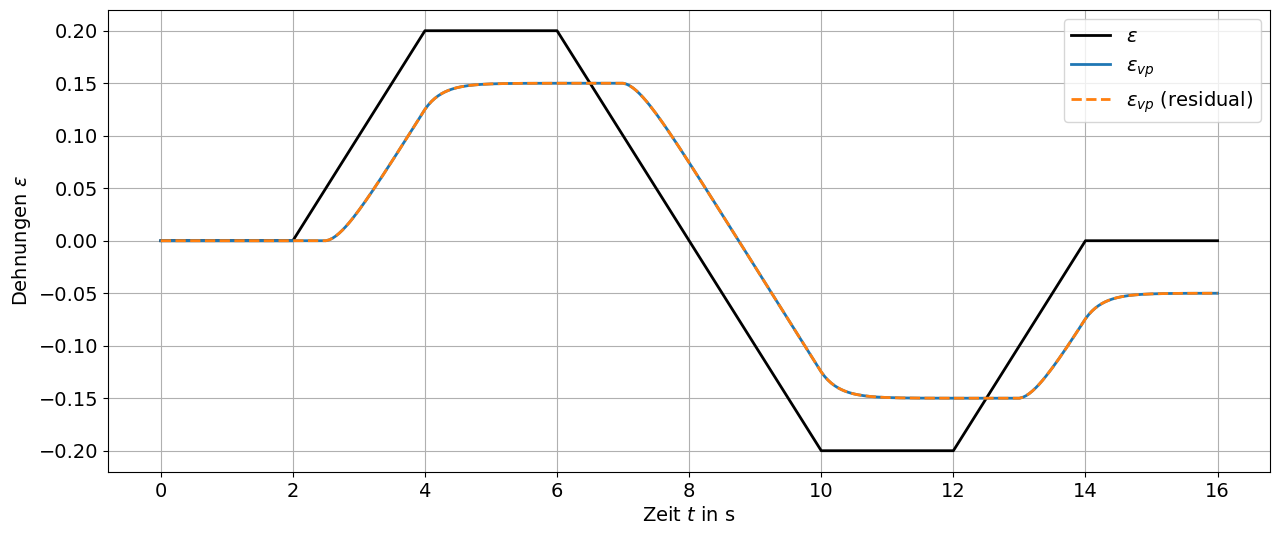

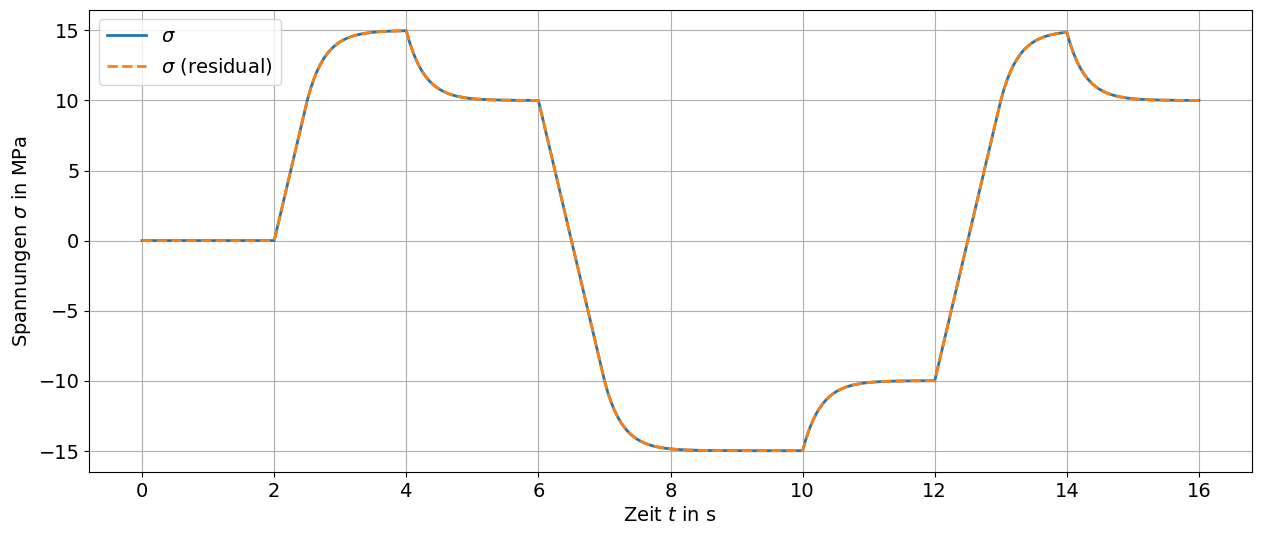

In [11]:
# Materialparameter
E = 200.
eta = 50.
sigy = 10.

# Diskrete Zeiten und Dehnungen
tmin = 0.
dt = 0.05

epsmax = 0.2
deps = 0.1 # Rate pro s
Ts = epsmax/deps # Zeit für Rampe
Th = 2. # Haltezeit

T1 = Th
T2 = Th+Ts
T3 = 2*Th+Ts
T4 = 2*Th+3*Ts
T5 = 3*Th+3*Ts
T6 = 3*Th+4*Ts

tmax = 4*Th+4*Ts

t = np.arange(tmin, tmax+dt, dt)

eps = (np.heaviside(t-T1,0)*(t-T1)*deps
      -np.heaviside(t-T2,0)*(t-T2)*deps
      -np.heaviside(t-T3,0)*(t-T3)*deps
      +np.heaviside(t-T4,0)*(t-T4)*deps
      +np.heaviside(t-T5,0)*(t-T5)*deps
      -np.heaviside(t-T6,0)*(t-T6)*deps)


# Leere Arrays für Spannung und interne Variable
sig = np.zeros_like(eps)
epsvp = np.zeros_like(eps) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

sig_res = np.zeros_like(eps)
epsvp_res = np.zeros_like(eps) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable


# Schleife über Zeitschritte
for i in range(1,len(eps)):
    sig[i], epsvp[i] = stress(eps[i], epsvp[i-1], dt, E, sigy, eta)
    sig_res[i], epsvp_res[i] = stress_res(eps[i], epsvp[i-1], dt, E, sigy, eta)
    
plt.figure()
plt.plot(t, eps, 'k', label=r'$\varepsilon$')
plt.plot(t, epsvp, '-', label=r'$\varepsilon_{vp}$')
plt.plot(t, epsvp_res, '--', label=r'$\varepsilon_{vp}$ (residual)')

plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$')
plt.ylabel(r'Dehnungen $\varepsilon$')

plt.figure()
plt.plot(t, sig, label=r'$\sigma$')
plt.plot(t, sig_res, '--', label=r'$\sigma$ (residual)')
plt.legend()
plt.xlabel('t');
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$');


# Inverses Problem

Wie bei der Viskoelastizität kann das residuale Format ausgenutzt werden um ohne große Änderungen die Spannungen vorzuschreiben.

---
**Aufgabe**

Vervollständige die Funktion `strain_res` zur Bestimmung der Dehnung und internen Variablen basierend auf der Residuumsfunktion.

---

In [12]:
# Lösung der Residuumsgleichung nach den Dehnungen und viskosen Verzerrungen
def strain_res(sig, epsvp_n, dt, E, sigy, eta, x0 = np.zeros(4)):
    
    #             res(eps,  sig, epsvp, dlambda, phi,  epsvp_n, dt, E, sigy, eta)
    f = lambda x: res(x[0], sig, x[1],  x[2],   x[3],  epsvp_n, dt, E, sigy, eta)    
    
    sol = fsolve(f, x0)
    
    return sol[0:2]

In [13]:
from musterloesungen import test_strain_res
test_strain_res(strain_res)

Die Funktion ist korrekt.


Hier wird statt der Dehnung die Spannung vorgeschrieben:

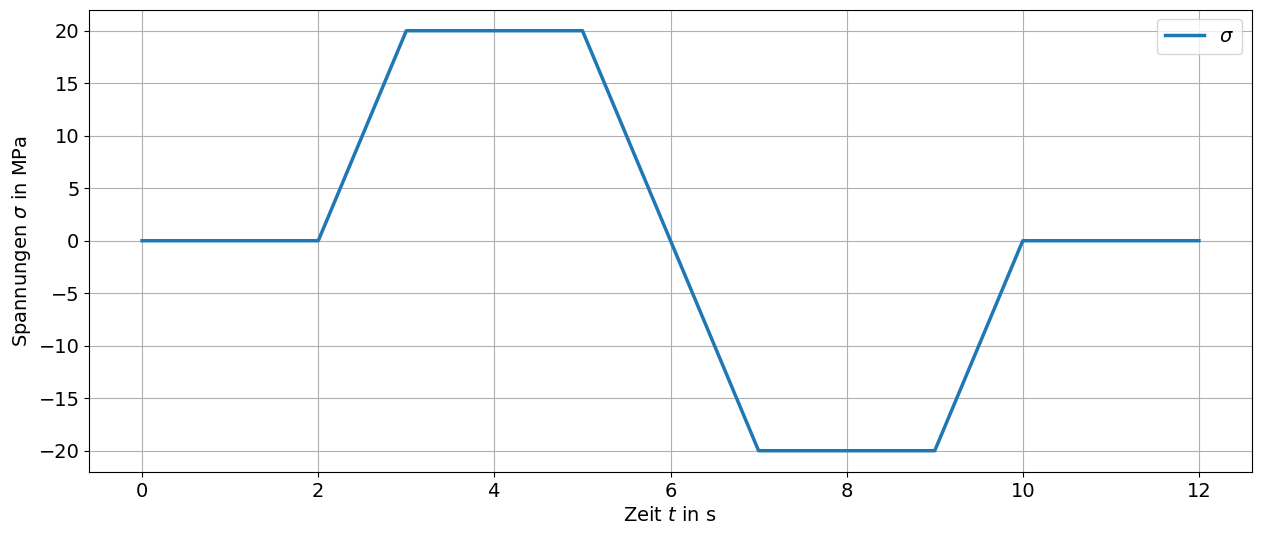

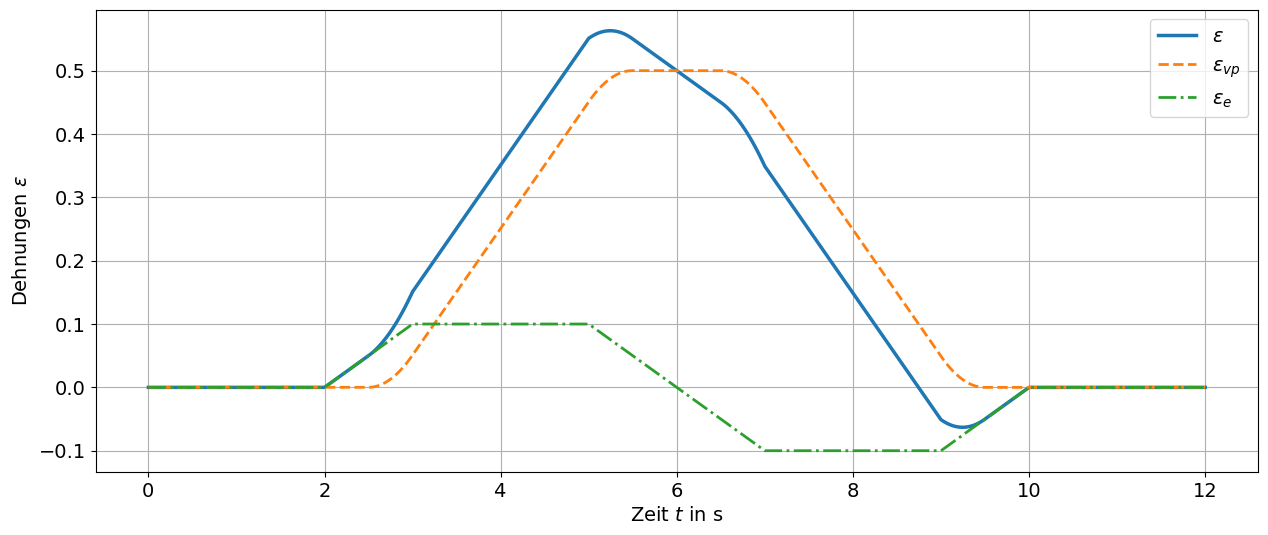

In [14]:
# Materialparameter
E = 200.
eta = 50.
sigy = 10.

# Diskrete Zeiten und Dehnungen
tmin = 0.
dt = 0.01

sigmax = 20
dsig = 20 # Rate pro s
Ts = sigmax/dsig # Zeit für Rampe
Th = 2. # Haltezeit

T1 = Th
T2 = Th+Ts
T3 = 2*Th+Ts
T4 = 2*Th+3*Ts
T5 = 3*Th+3*Ts
T6 = 3*Th+4*Ts

tmax = 4*Th+4*Ts

t = np.arange(tmin, tmax+dt, dt)

sig = (np.heaviside(t-T1,0)*(t-T1)*dsig
      -np.heaviside(t-T2,0)*(t-T2)*dsig
      -np.heaviside(t-T3,0)*(t-T3)*dsig
      +np.heaviside(t-T4,0)*(t-T4)*dsig
      +np.heaviside(t-T5,0)*(t-T5)*dsig
      -np.heaviside(t-T6,0)*(t-T6)*dsig)


# Leere Arrays für Spannung und interne Variable
eps = np.zeros_like(sig)
epsvp = np.zeros_like(sig) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

# Schleife über Zeitschritte
for i in range(1,len(eps)):
    eps[i], epsvp[i] = strain_res(sig[i], epsvp[i-1], dt, E, sigy, eta)

plt.figure()
plt.plot(t, sig, label=r'$\sigma$', linewidth=2.5)
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$')

plt.figure()
plt.plot(t, eps, label=r'$\varepsilon$', linewidth=2.5)
plt.plot(t, epsvp, '--', label=r'$\varepsilon_{vp}$')
plt.plot(t, eps - epsvp, '-.', label=r'$\varepsilon_e$')
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$');


# Weiterführende Aufgaben

Die folgenden Aufgaben können selbstständig bearbeitet werden, um das eigene Verständnis zu verbessern und sich intensiver mit dem Programm auseinander zu setzen

- Erweitere deinen Code, sodass die einzelnen Komponenten der Spannungen geplottet werden. Überlege zunächst, wie dies mit möglichst geringen Änderungen erreicht werden kann.
- Erweitere das letzte Beispiel, so dass im Plot klar wird woraus die Änderungen in der Form der Dehnungskurve resultieren.
- Untersuche den Einfluss verschiedener Parameter analog zur Übung Viskoelastizität
